### Libraries

In [2]:
import yaml
import torch
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader

import random

from src.data.dataset import ImageSegmentationDataset
from src.utils.load_model import load_model
from src.utils.utils import one_hot_decoding

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


##### LOAD CONFIGS #####
with open('src/config/interference_config.yml', 'r') as file:
    config = yaml.safe_load(file)

with open('src/config/config.yml', 'r') as file:
    model_config = yaml.safe_load(file)



##### PARAMETERS #####
MODEL_SELECTION = config['MODEL_SELECTION']

IMAGE_SIZE = model_config['IMAGE_SIZE']
INPUT_CHANNELS = model_config['INPUT_CHANNELS']
OUTPUT_CHANNELS = model_config['OUTPUT_CHANNELS']

BATCH_SIZE = config['BATCH_SIZE']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
patches = torch.ones(2, 100, 20)

cls = torch.ones(2, 13, 20).transpose(1, 2)

test = patches @ cls

In [4]:
test.shape

torch.Size([2, 100, 13])

### Dataset & Dataloader

In [5]:
transform = T.Compose([
    T.Resize([IMAGE_SIZE, IMAGE_SIZE], interpolation=T.InterpolationMode.NEAREST)
])


test_dataset = ImageSegmentationDataset(
    dir_file= config['TEST_CSV'],
    n_channels = INPUT_CHANNELS,
    n_classes = OUTPUT_CHANNELS,
    transform = transform # add more transform functions
)


test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)

### Showing Images and Masks

In [6]:
flair_data = {
    0   : ['building','#db0e9a'] ,
    1   : ['pervious surface','#938e7b'],
    2   : ['impervious surface','#f80c00'],
    3   : ['bare soil','#a97101'],
    4   : ['water','#1553ae'],
    5   : ['coniferous','#194a26'],
    6   : ['deciduous','#46e483'],
    7   : ['brushwood','#f3a60d'],
    8   : ['vineyard','#660082'],
    9   : ['herbaceous vegetation','#55ff00'],
    10  : ['agricultural land','#fff30d'],
    11  : ['plowed land','#e4df7c'],
    12  : ['other','#3de6eb'],
}

labels = [flair_data[x][0] for x in flair_data]
colormap =  [flair_data[x][1] for x in flair_data]

In [7]:
def show_images(images):
  fig, axis = plt.subplots(1, len(images), figsize=(len(images) * 4, len(images) * 5))

  for idx, image in enumerate(images):
    image = image.type(torch.uint8)
    if len(image.shape) == 2:
      image = image.unsqueeze(dim=0)

    image = axis[idx].imshow(image.permute(1, 2, 0))

  plt.show()

In [8]:
def prepare_mask_visual(mask, colormap, n_colors=13):

    mask = mask.type(torch.uint8)
    if len(mask.shape) == 2:
      mask = mask.unsqueeze(dim=0)


    # Define the colors (13 distinct colors)
    cmap = mcolors.ListedColormap(colormap)

    # Normalize the colormap
    bounds = np.arange(-0.5, n_colors, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    return mask, cmap, norm

In [9]:
def show_mask(mask, colormap, labels, n_colors=13):

    mask, cmap, norm = prepare_mask_visual(mask, colormap, n_colors)

    # Create the plot
    fig, ax = plt.subplots()
    mask = ax.imshow(mask.permute(1, 2, 0), cmap=cmap, norm=norm, interpolation='nearest')

    # Optional: Add color bar with appropriate ticks
    cbar = fig.colorbar(mask, ticks=np.arange(0, n_colors))
    cbar.ax.set_yticklabels(labels)

    # Show the plot
    plt.show()

In [10]:
def show_images_and_masks(images, masks, n_colors=13, compare=False):
  im_len = len(images) + len(masks)
  fig, axis = plt.subplots(1, im_len, figsize=(im_len * 4, im_len * 5))

  for idx, image in enumerate(images):
    image = image.type(torch.uint8)
    if len(image.shape) == 2:
      image = image.unsqueeze(dim=0)

    image = axis[idx].imshow(image.permute(1, 2, 0))

  for idx, mask in enumerate(masks):
    mask = mask.type(torch.uint8)
    if len(mask.shape) == 2:
      mask = mask.unsqueeze(dim=0)

    mask, cmap, norm = prepare_mask_visual(mask, colormap, n_colors)

    mask = axis[idx + len(images)].imshow(mask.permute(1, 2, 0), cmap=cmap, norm=norm, interpolation='nearest')

  if compare and len(masks) == 2:
    # iou_metric = MulticlassJaccardIndex(n_colors)
    # iou = iou_metric(masks[0], masks[1])

    compared_masks = masks[0] == masks[1]
    similarity = (compared_masks.sum() / masks[0].numel()).item() * 100

    axis[im_len - 2].set_title(f'Ground truth')
    
    axis[im_len - 1].set_title(f'PixelAccuracy: {similarity:.2f}%')
    # axis[im_len - 1].set_title(f'PixelAccuracy: {similarity:.2f}%\nmIoU: {iou:.4f}')

  plt.show()

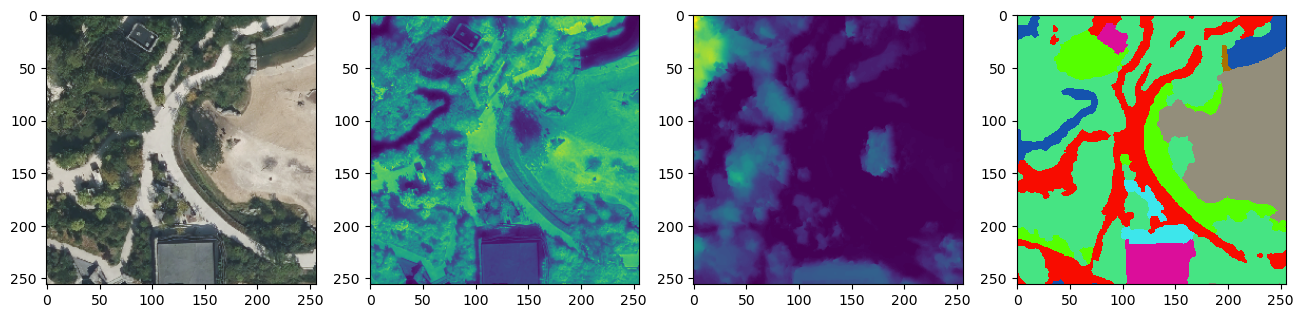

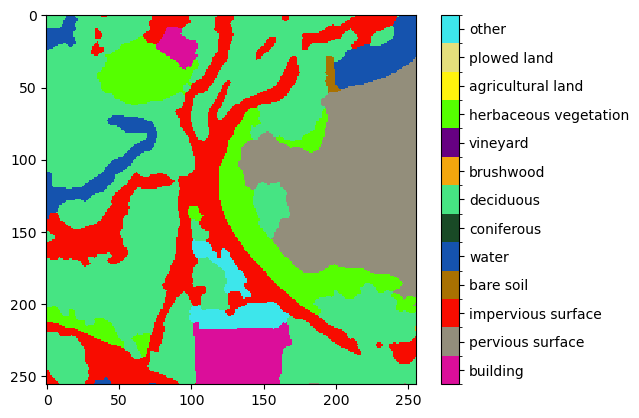

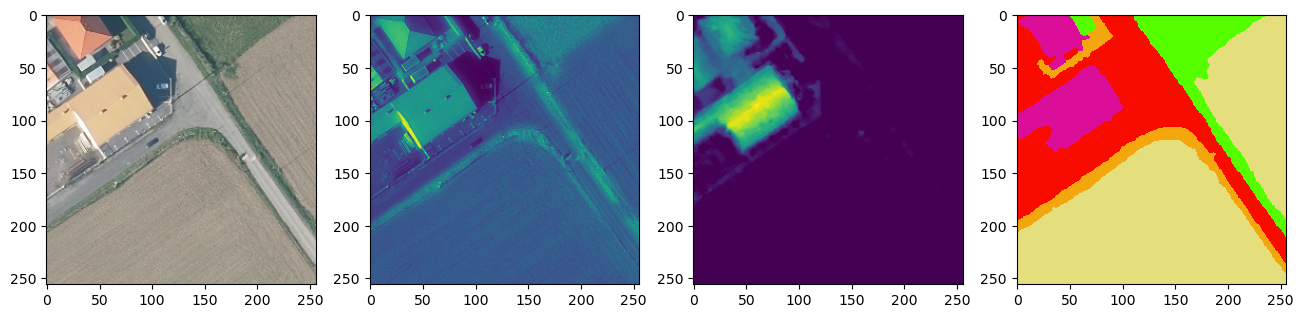

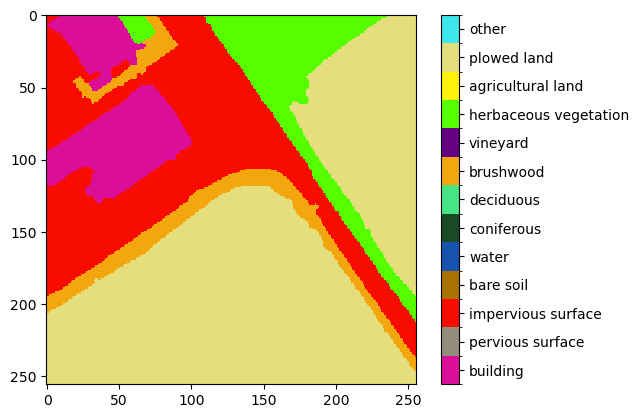

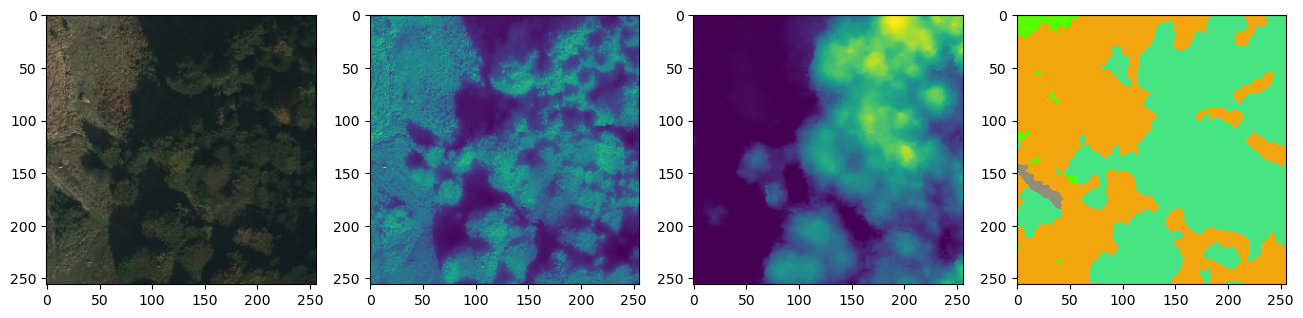

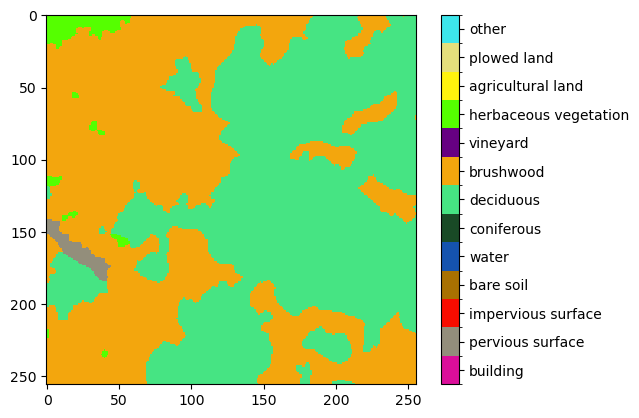

In [11]:
for i in range(3):
    image, mask  = random.choice(test_dataset)
    
    image_rgb = image[:3, :, :]
    image_nir = image[3, :, :]
    image_el = image[4, :, :]

    show_images_and_masks([image_rgb, image_nir, image_el], [mask], OUTPUT_CHANNELS)
    show_mask(mask, colormap, labels, OUTPUT_CHANNELS)

### Create Models list

In [19]:
models_name_list = ['UNet', 'UNet++', 'ViTSegmenter', 'ResViTSegmenter']

models_list = []
for model_name in models_name_list:

    model = load_model(model_name, model_config)
    checkpoint = torch.load(model_config['MODEL'][model_name]['ckp'])
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'Model: {model_name} loaded')

    models_list.append(model)



Model: UNet loaded
Model: UNet++ loaded
Model: ViTSegmenter loaded
Model: ResViTSegmenter loaded


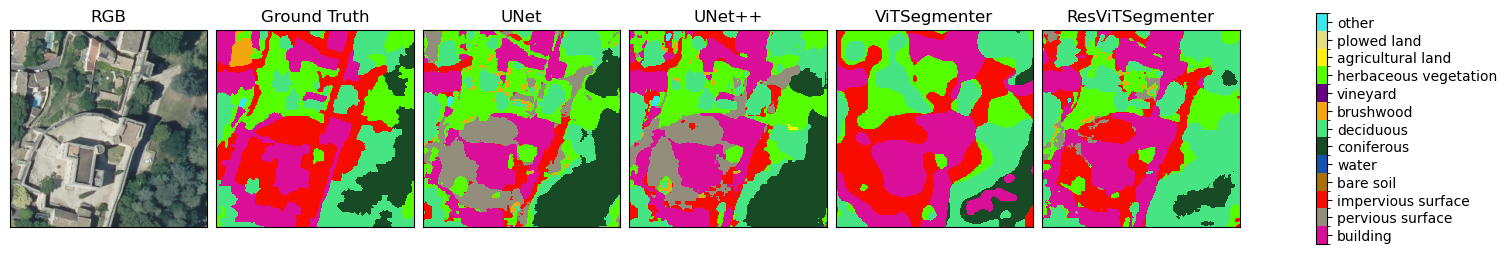

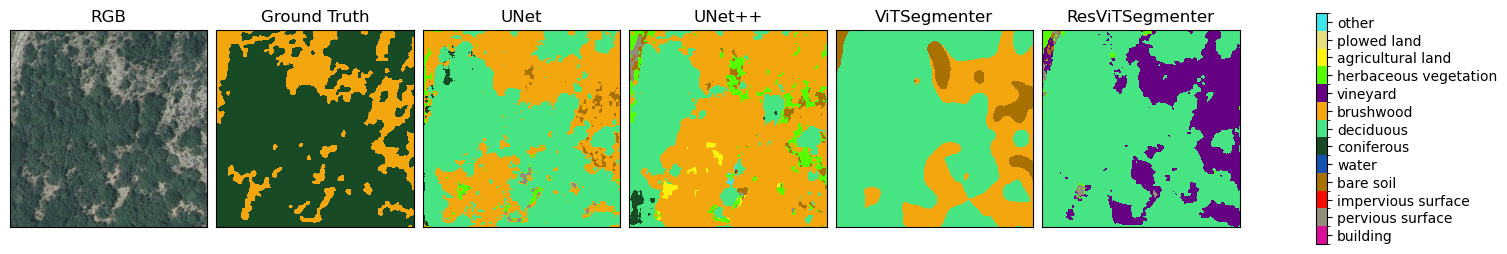

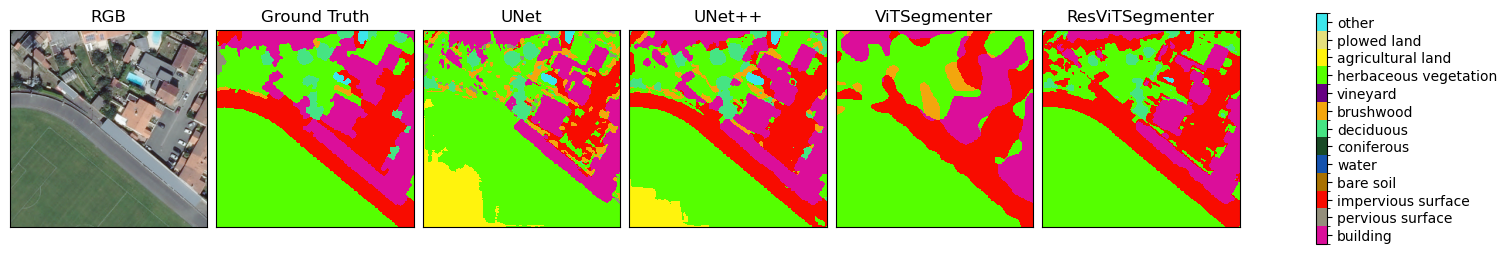

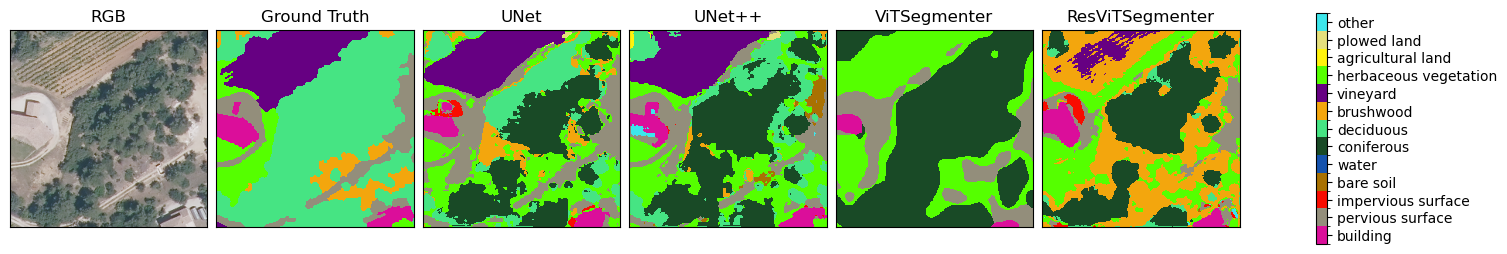

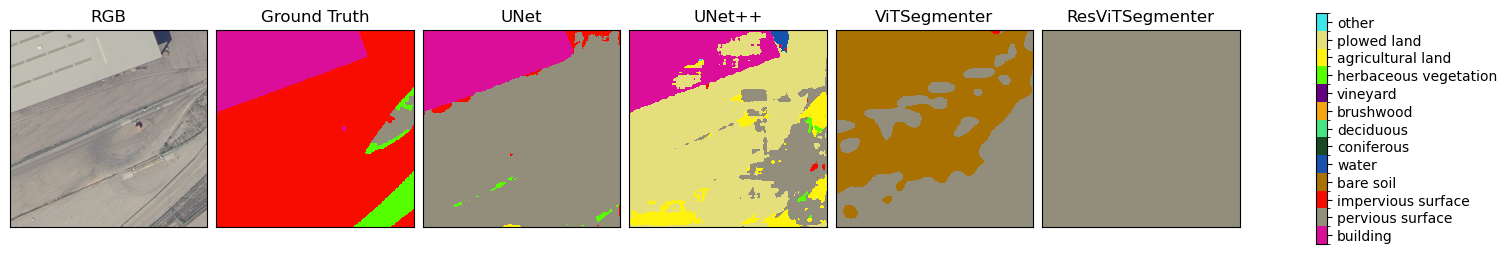

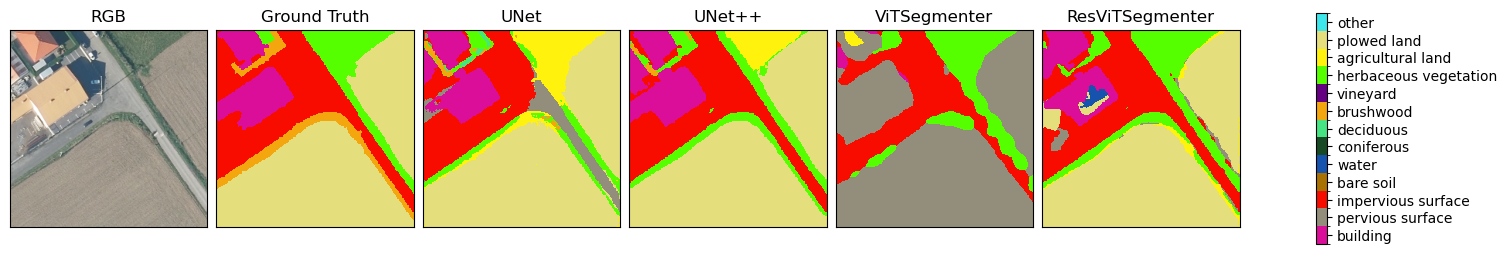

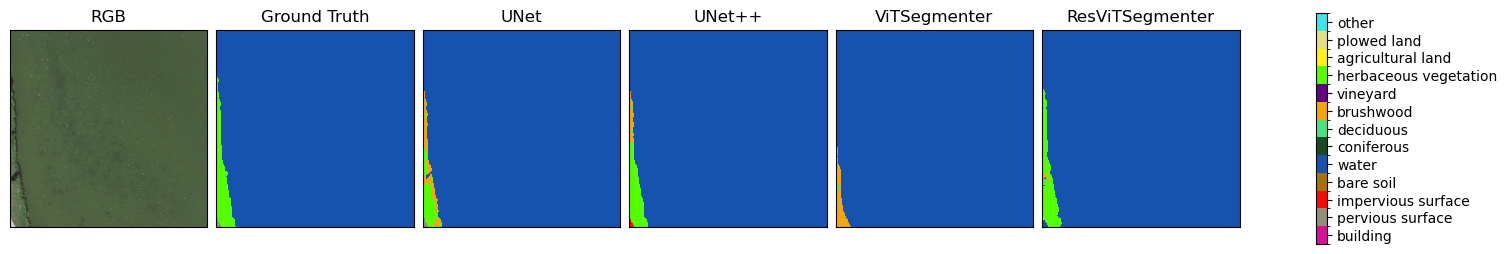

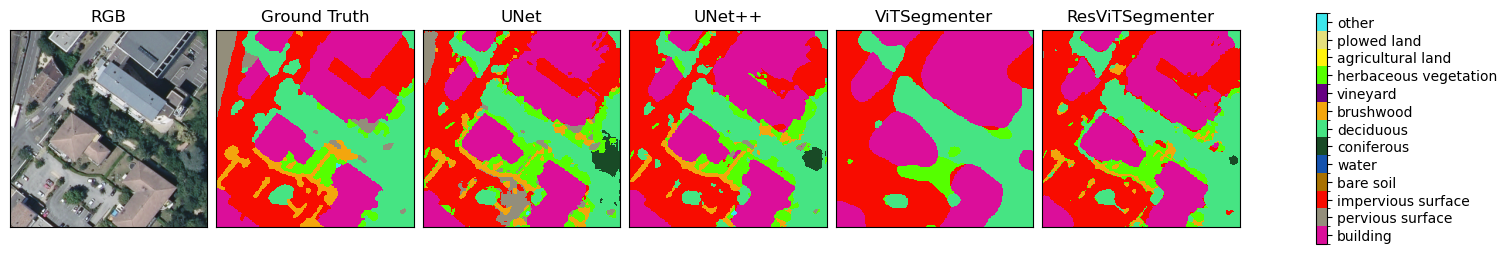

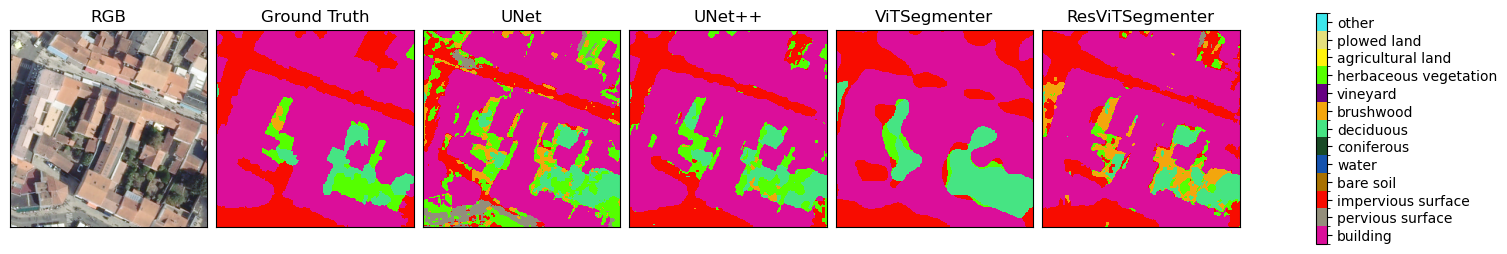

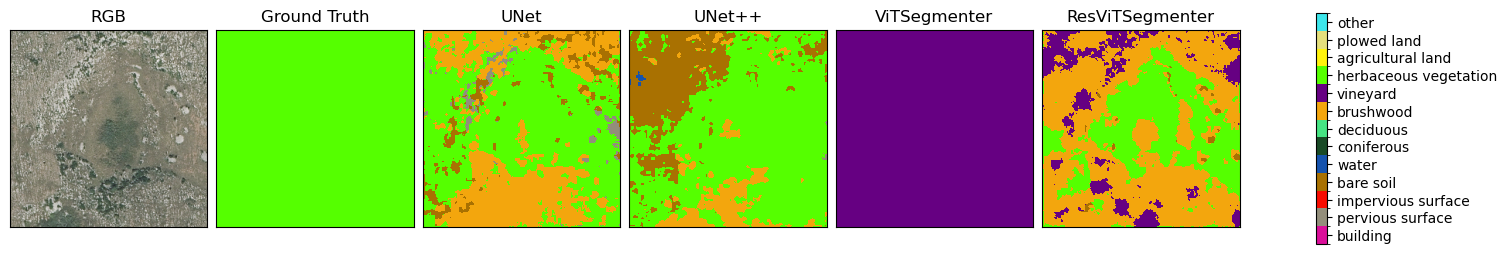

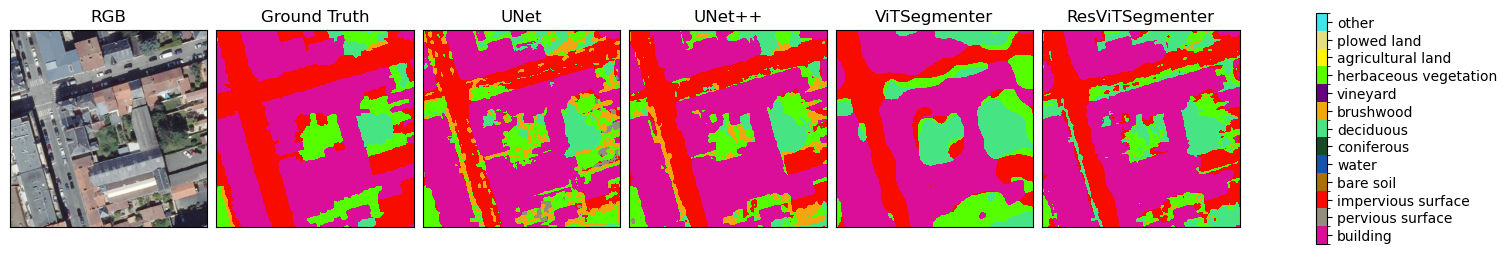

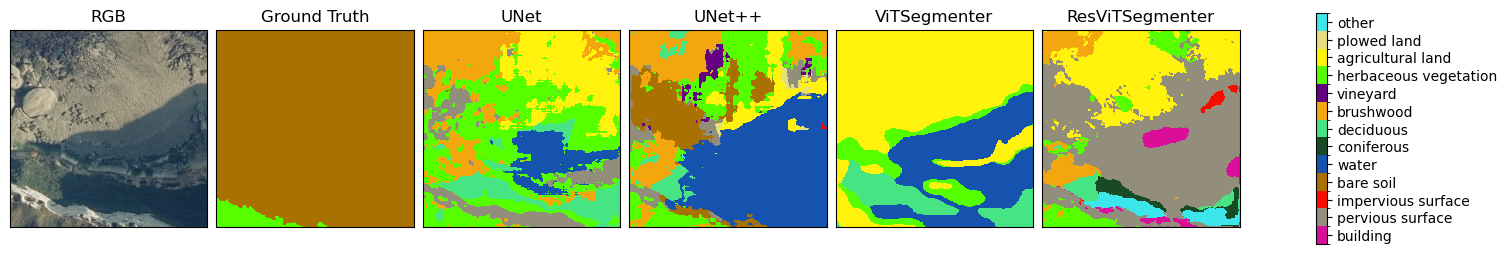

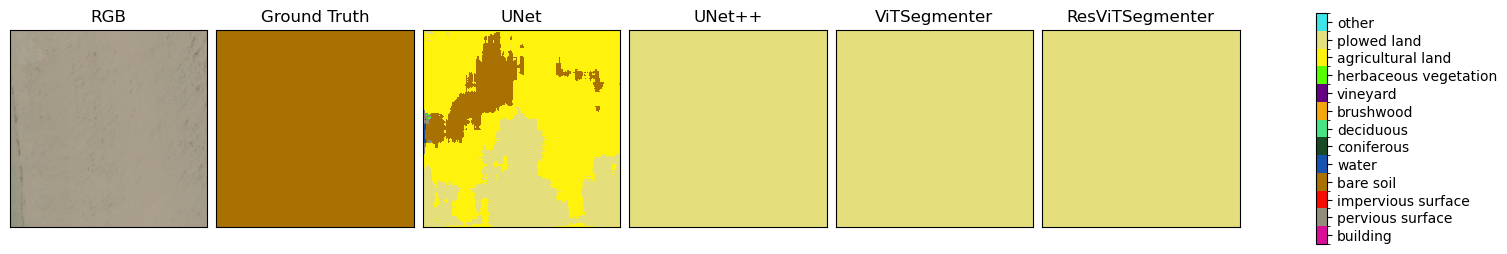

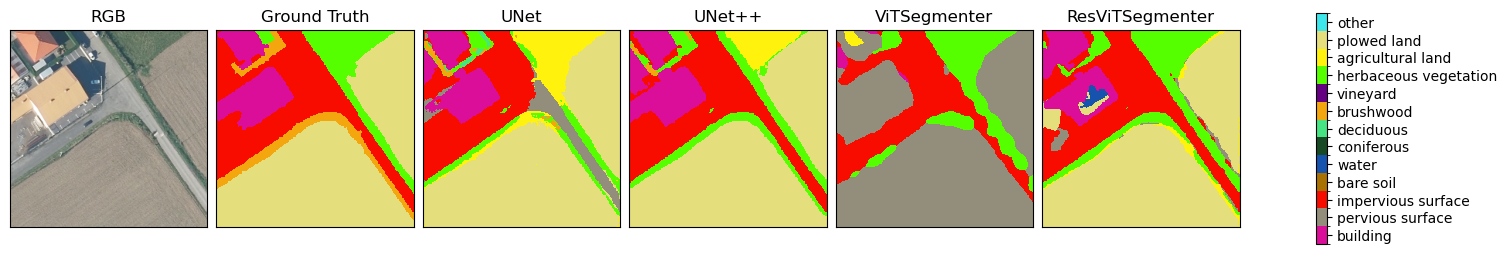

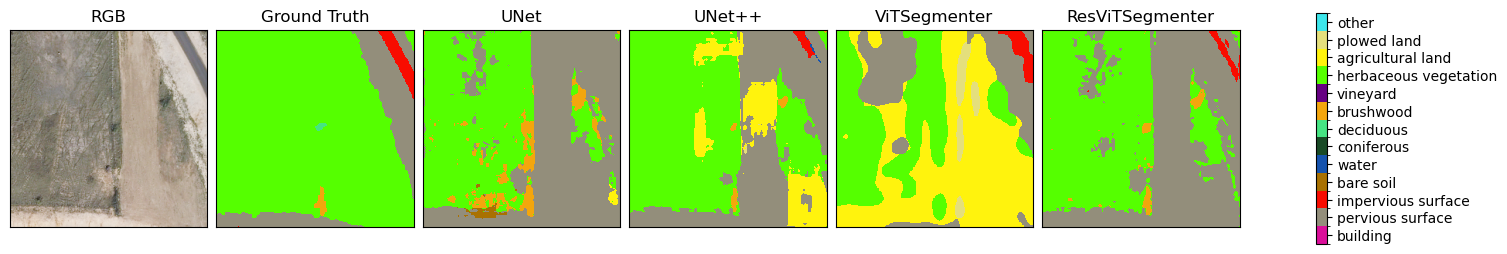

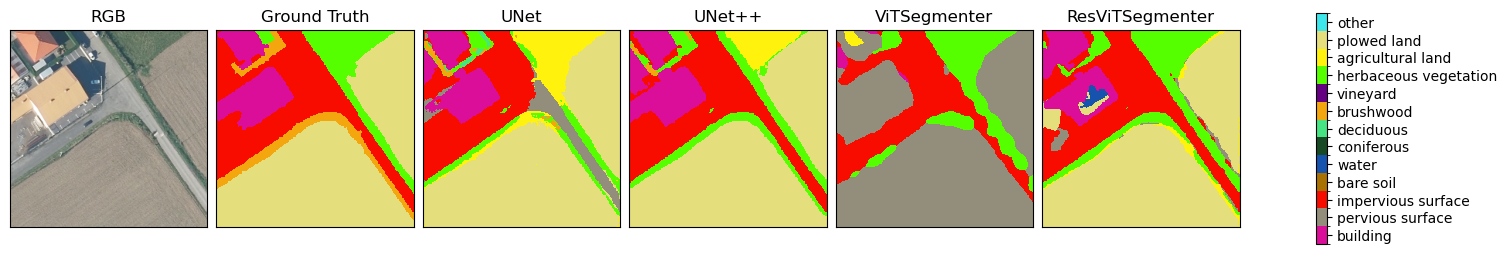

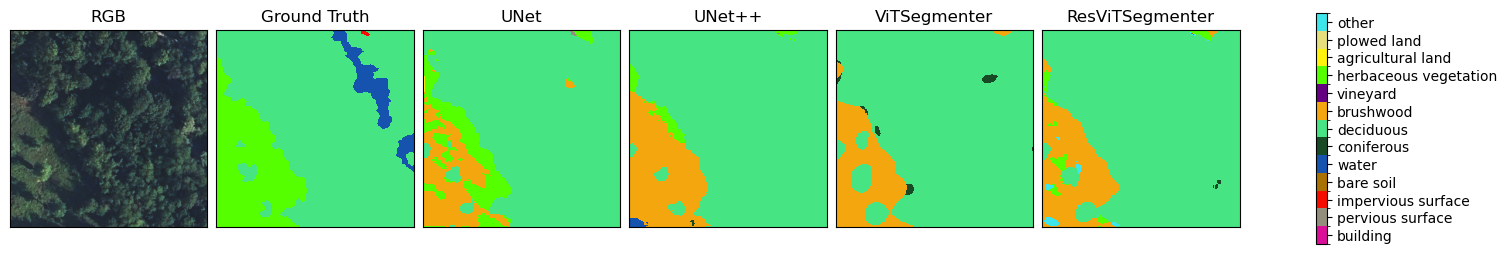

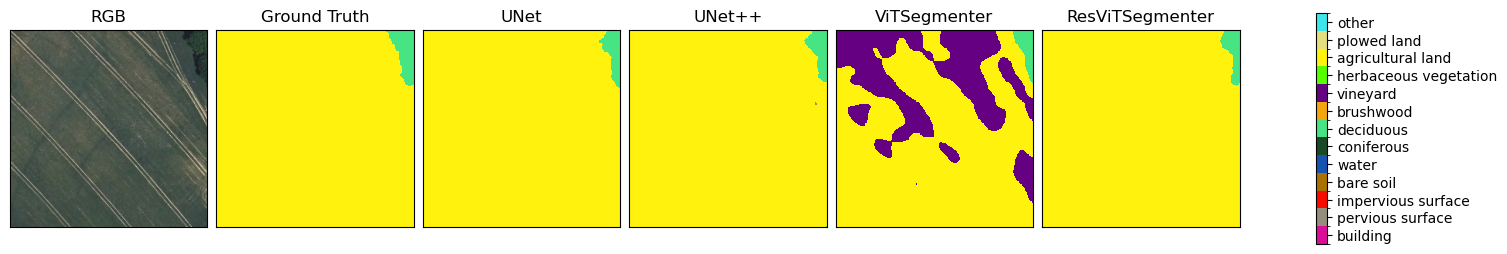

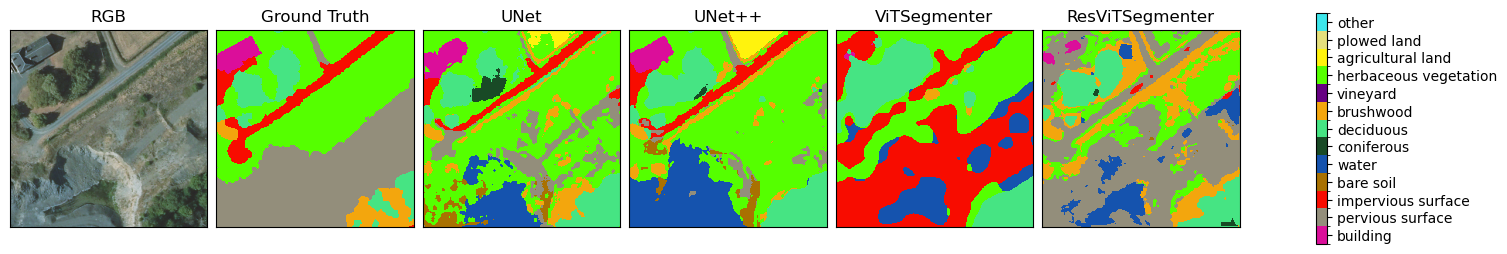

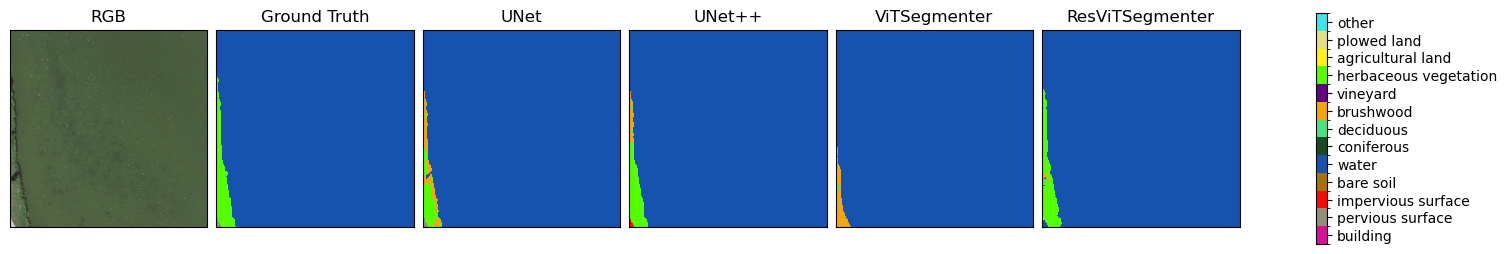

In [191]:
num_photos = 20

for photo_idx in range(num_photos):

    # Create a figure and a gridspec layout
    fig, axes = plt.subplots(1, len(models_name_list) + 3, figsize=(17, 3), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 0.4]})

    # Choose random photo
    satellite_photo = random.choice(test_dataset)

    # Set RGB and ground truth 
    rgb = satellite_photo[0][:3].type(torch.uint8)
    ground_truth = satellite_photo[1].unsqueeze(0)

    # Display RGB image
    axes[0].imshow(rgb.permute(1, 2, 0))
    axes[0].set_title("RGB")
    
    # Prepare and display the ground truth
    ground_truth, cmap, norm = prepare_mask_visual(ground_truth, colormap, len(flair_data))
    ground_truth_im = axes[1].imshow(ground_truth.permute(1, 2, 0), cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title("Ground Truth")

    # Remove axis ticks from the first two plots
    for ax in axes[:2]:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

    # Loop through models and display predictions
    for idx, model in enumerate(models_list, 2):
        model.eval()
        model_pred = model(satellite_photo[0].unsqueeze(0))
        model_pred_mask = one_hot_decoding(model_pred, dim=1)
        
        axes[idx].imshow(model_pred_mask.permute(1, 2, 0), cmap=cmap, norm=norm, interpolation='nearest')
        axes[idx].set_title(models_name_list[idx - 2])
        axes[idx].get_xaxis().set_ticks([])
        axes[idx].get_yaxis().set_ticks([])

    # Turn off the axis for the colorbar subplot
    axes[len(models_name_list) + 2].axis('off')

    # Add the colorbar to the last (narrow) subplot
    cbar = fig.colorbar(ground_truth_im, ax=axes[len(models_name_list) + 2], ticks=np.arange(0, len(flair_data)))
    cbar.ax.set_yticklabels(labels)

    # Adjust layout to remove extra whitespace
    plt.subplots_adjust(wspace=0.05)  # Decrease horizontal spacing

    plt.show()
